In [1]:
import sys
sys.path.insert(0,'..')
sys.path.insert(0,'../../WobbleSim')
import simulacra.dataset
import astropy
import astropy.units as u 
import astropy.coordinates as coord
import astropy.time as at
import astropy.constants as const
import numpy as np
import math
import scipy.optimize

import jabble.dataset
import jabble.loss
import jabble.model
import jabble.physics

import matplotlib.pyplot as plt

from collections import namedtuple
from jaxopt import GaussNewton
import jax.numpy as jnp
import jax

from jax.config import config; config.update("jax_enable_x64", True)

/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:172: SyntaxWarning: Jitted function has static_argnums=(3, 4), but only accepts 4 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "
/ext3/miniconda3/envs/wobbleenv/lib/python3.11/site-packages/jax/_src/api_util.py:172: SyntaxWarning: Jitted function has static_argnums=(3, 4, 5), but only accepts 5 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "


In [2]:
import scipy.constants

<h1>44 - simple data varying splines n lines</h1>


In [3]:
import os
import datetime
today = datetime.date.today()
out_dir = os.path.join('..','out',today.strftime("%d-%m-%y"))
os.makedirs(out_dir,exist_ok=True)

In [4]:
def gaussian(x,mu,sigma):
    return np.exp(-(x - mu)**2/(2 * sigma**2)) #/ (2 * sigma * np.sqrt(2 * np.pi))

In [5]:
class GaussianModel(jabble.model.Model):
    def __init__(self,means,heights,resolution):
        super(GaussianModel, self).__init__()
        self.p = means
        self.heights = heights
        self.dx = jabble.dataset.delta_x(resolution)

    def call(self,p,x,i,*args):
        flux = np.ones(x.shape,dtype='float64') 
        
        for i,mean in enumerate(p):
            flux -= self.heights[i] * gaussian(x,mean,self.dx)
    
        return np.log(flux)

In [6]:
def create_dataset(x_grid,true_model,snr,resolution):
    
    flux = np.zeros((epoches,*x_grid.shape),dtype=np.float64)
    for i in range(epoches):
        flux[i,:] = np.exp(true_model([],x_grid,i))

    # add noise
    for j in range(flux.shape[0]):
        for k in range(flux.shape[1]):
            flux[j,k] -= np.random.normal(0.0,np.abs(flux[j,k]/snr))

    ferr = flux/snr
    yerr = ferr/flux
    mask = np.zeros(flux.shape)
    # dataset = MyData(x_grid[None,:].repeat(epoches,0),np.log(flux),1/yerr**2)
    dataset = jabble.dataset.Dataset(x_grid[None,:].repeat(epoches,0),np.log(flux),yerr,mask)
    return dataset

In [7]:
resolution = 120_000
snr        = 50
epoches    = 20

dx = jabble.dataset.delta_x(2*resolution)
lmin = 4560
lmax = 4600
n = 10
n2 = 2
x_grid    = np.arange(np.log(lmin),np.log(lmax),step=dx,dtype='float64')

wave_grid = np.exp(x_grid) * u.Angstrom

guess_vel  = np.linspace(-60,60,epoches) * u.km/u.s
extra_vel  = np.linspace(-30,30,epoches) * u.m/u.s
velocities = guess_vel + extra_vel
shifts     = jabble.dataset.shifts(velocities).value

line_padding = np.exp(np.max(shifts))
means_stellar = np.log(np.random.uniform(lmin + line_padding,lmax - line_padding,n))
heigt_stellar = np.random.uniform(0.3,0.7,n)
means_tellurics = np.log(np.random.uniform(lmin + line_padding,lmax - line_padding,n))
heigt_tellurics = np.random.uniform(0.3,0.7,n)

true_model = jabble.model.CompositeModel([jabble.model.ShiftingModel(shifts),GaussianModel(means_stellar,heigt_stellar,resolution)])\
           + GaussianModel(means_tellurics,heigt_tellurics,resolution)

means_stellar = np.log(np.random.uniform(lmin + line_padding,lmax - line_padding,n2))
heigt_stellar = np.random.uniform(0.3,0.7,n2)
means_tellurics = np.log(np.random.uniform(lmin + line_padding,lmax - line_padding,n2))
heigt_tellurics = np.random.uniform(0.3,0.7,n2)

true_model2 = jabble.model.CompositeModel([jabble.model.ShiftingModel(shifts),GaussianModel(means_stellar,heigt_stellar,resolution)])\
            + GaussianModel(means_tellurics,heigt_tellurics,resolution)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [8]:
datasets = [create_dataset(x_grid,true_model,snr,resolution),\
            create_dataset(x_grid,true_model,snr/2,resolution),\
            create_dataset(x_grid,true_model2,snr,resolution),\
            create_dataset(x_grid,true_model2,snr/2,resolution)]

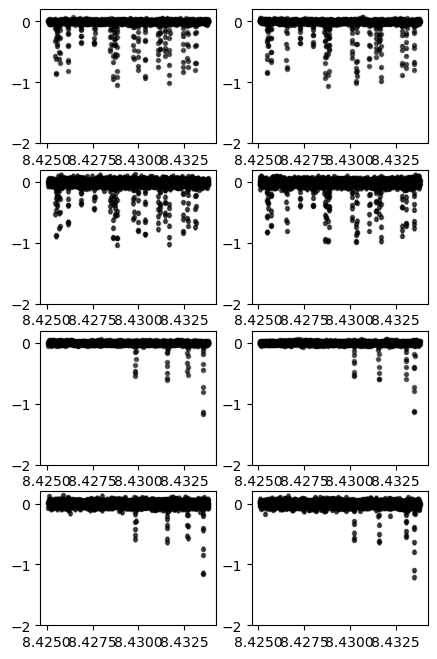

In [9]:
plt_inds = epoches
xpmin = np.log(4550)
xpmax = np.log(4560)
fig, axes = plt.subplots(len(datasets),2,figsize=(5,8))
for i,dataset in enumerate(datasets):
    axes[i,0].errorbar(datasets[i].xs[0,:],datasets[i].ys[0,:],datasets[i].yerr[0,:],fmt='.k',elinewidth=2.2,zorder=1,alpha=0.5,ms=6)
    axes[i,1].errorbar(datasets[i].xs[-1,:],datasets[i].ys[-1,:],datasets[i].yerr[-1,:],fmt='.k',elinewidth=2.2,zorder=1,alpha=0.5,ms=6)

#     axes[ele].set_xlim(xpmin-shifts[ele],xpmax-shifts[ele])
    axes[i,0].set_ylim(-2,0.2)
    axes[i,1].set_ylim(-2,0.2)
plt.show() 

In [10]:

init_vels   = guess_vel
init_shifts = jabble.dataset.shifts(init_vels)

In [11]:
init_shifts.dtype

dtype('float64')

In [12]:
def train_cycle(model,dataset,loss):
    n_cycles = 1

    options1 = {'pgtol': 0.0}
    options2 = {'pgtol': 0.0}
    for iii in range(n_cycles):
        
        model.fix()
        model.fit(0,1)
        res1 = model.new_lbfgsb(loss,dataset,options=options1)
        print(res1['warnflag'],res1['nit'])
        if res1['warnflag'] == 2:
            print(res1['task'])
        
        model.fix()
        model.fit(1)
        res1 = model.new_lbfgsb(loss,dataset,options=options2)
        print(res1['warnflag'],res1['nit'])
        if res1['warnflag'] == 2:
            print(res1['task'])

        model.fix()
        model.fit(0,0)
        res1 = model.new_lbfgsb(loss,dataset,options=options1)
        print(res1['warnflag'],res1['nit'])
        if res1['warnflag'] == 2:
            print(res1['task'])

        model.fix()
        shift_search = jabble.physics.shifts(np.linspace(-10,10,100))
        model[0][0].parabola_fit(shift_search,loss,model,dataset)
            
        model.fix()
        model.fit(0,0)
        model.fit(0,1)
        model.fit(1)
        res1 = model.new_lbfgsb(loss,dataset,options=options2)
        print(res1['warnflag'],res1['nit'])
        if res1['warnflag'] == 2:
            print(res1['task'])
        
    return model

In [13]:
class MyModel(jabble.model.CompositeModel):
    
    def gaussnewton(self,data,*args):
        # Fits the Model
        def chi_1(p):
            residual = jnp.zeros(data.xs.shape)
            for i in range(data.xs.shape[0]):
                
                residual = residual.at[i,:].set((data.ys[i,:] - self(p,data.xs[i,:],i)) * data.yivar[i,:])
            return residual
        

        gn = GaussNewton(residual_fun=chi_1)
        gn_sol = gn.run(self.get_parameters())
        
        self.results.append(gn_sol)
        self.unpack(gn_sol.params)
        return gn_sol

In [14]:
vel_padding = 100 * u.km/u.s
p_val = 2
model_grid = jabble.model.create_x_grid(x_grid,vel_padding,2*resolution)#step=jabble.dataset.shifts(const.c.to(u.km/u.s)/resolution))
filenames = ['testdata_snr{}_20.stats'.format(snr),'testdata_snr{}_20.stats'.format(snr/2),'testdata_snr{}_5.stats'.format(snr),'testdata_snr{}_5.stats'.format(snr/2)]
def create_model():
    return MyModel([jabble.model.ShiftingModel(init_shifts),jabble.model.IrwinHallModel_sparse(model_grid,p_val)])\
    + jabble.model.IrwinHallModel_sparse(model_grid,p_val)
model_set = [create_model() for x in datasets]# for j in range(len(datasets))]

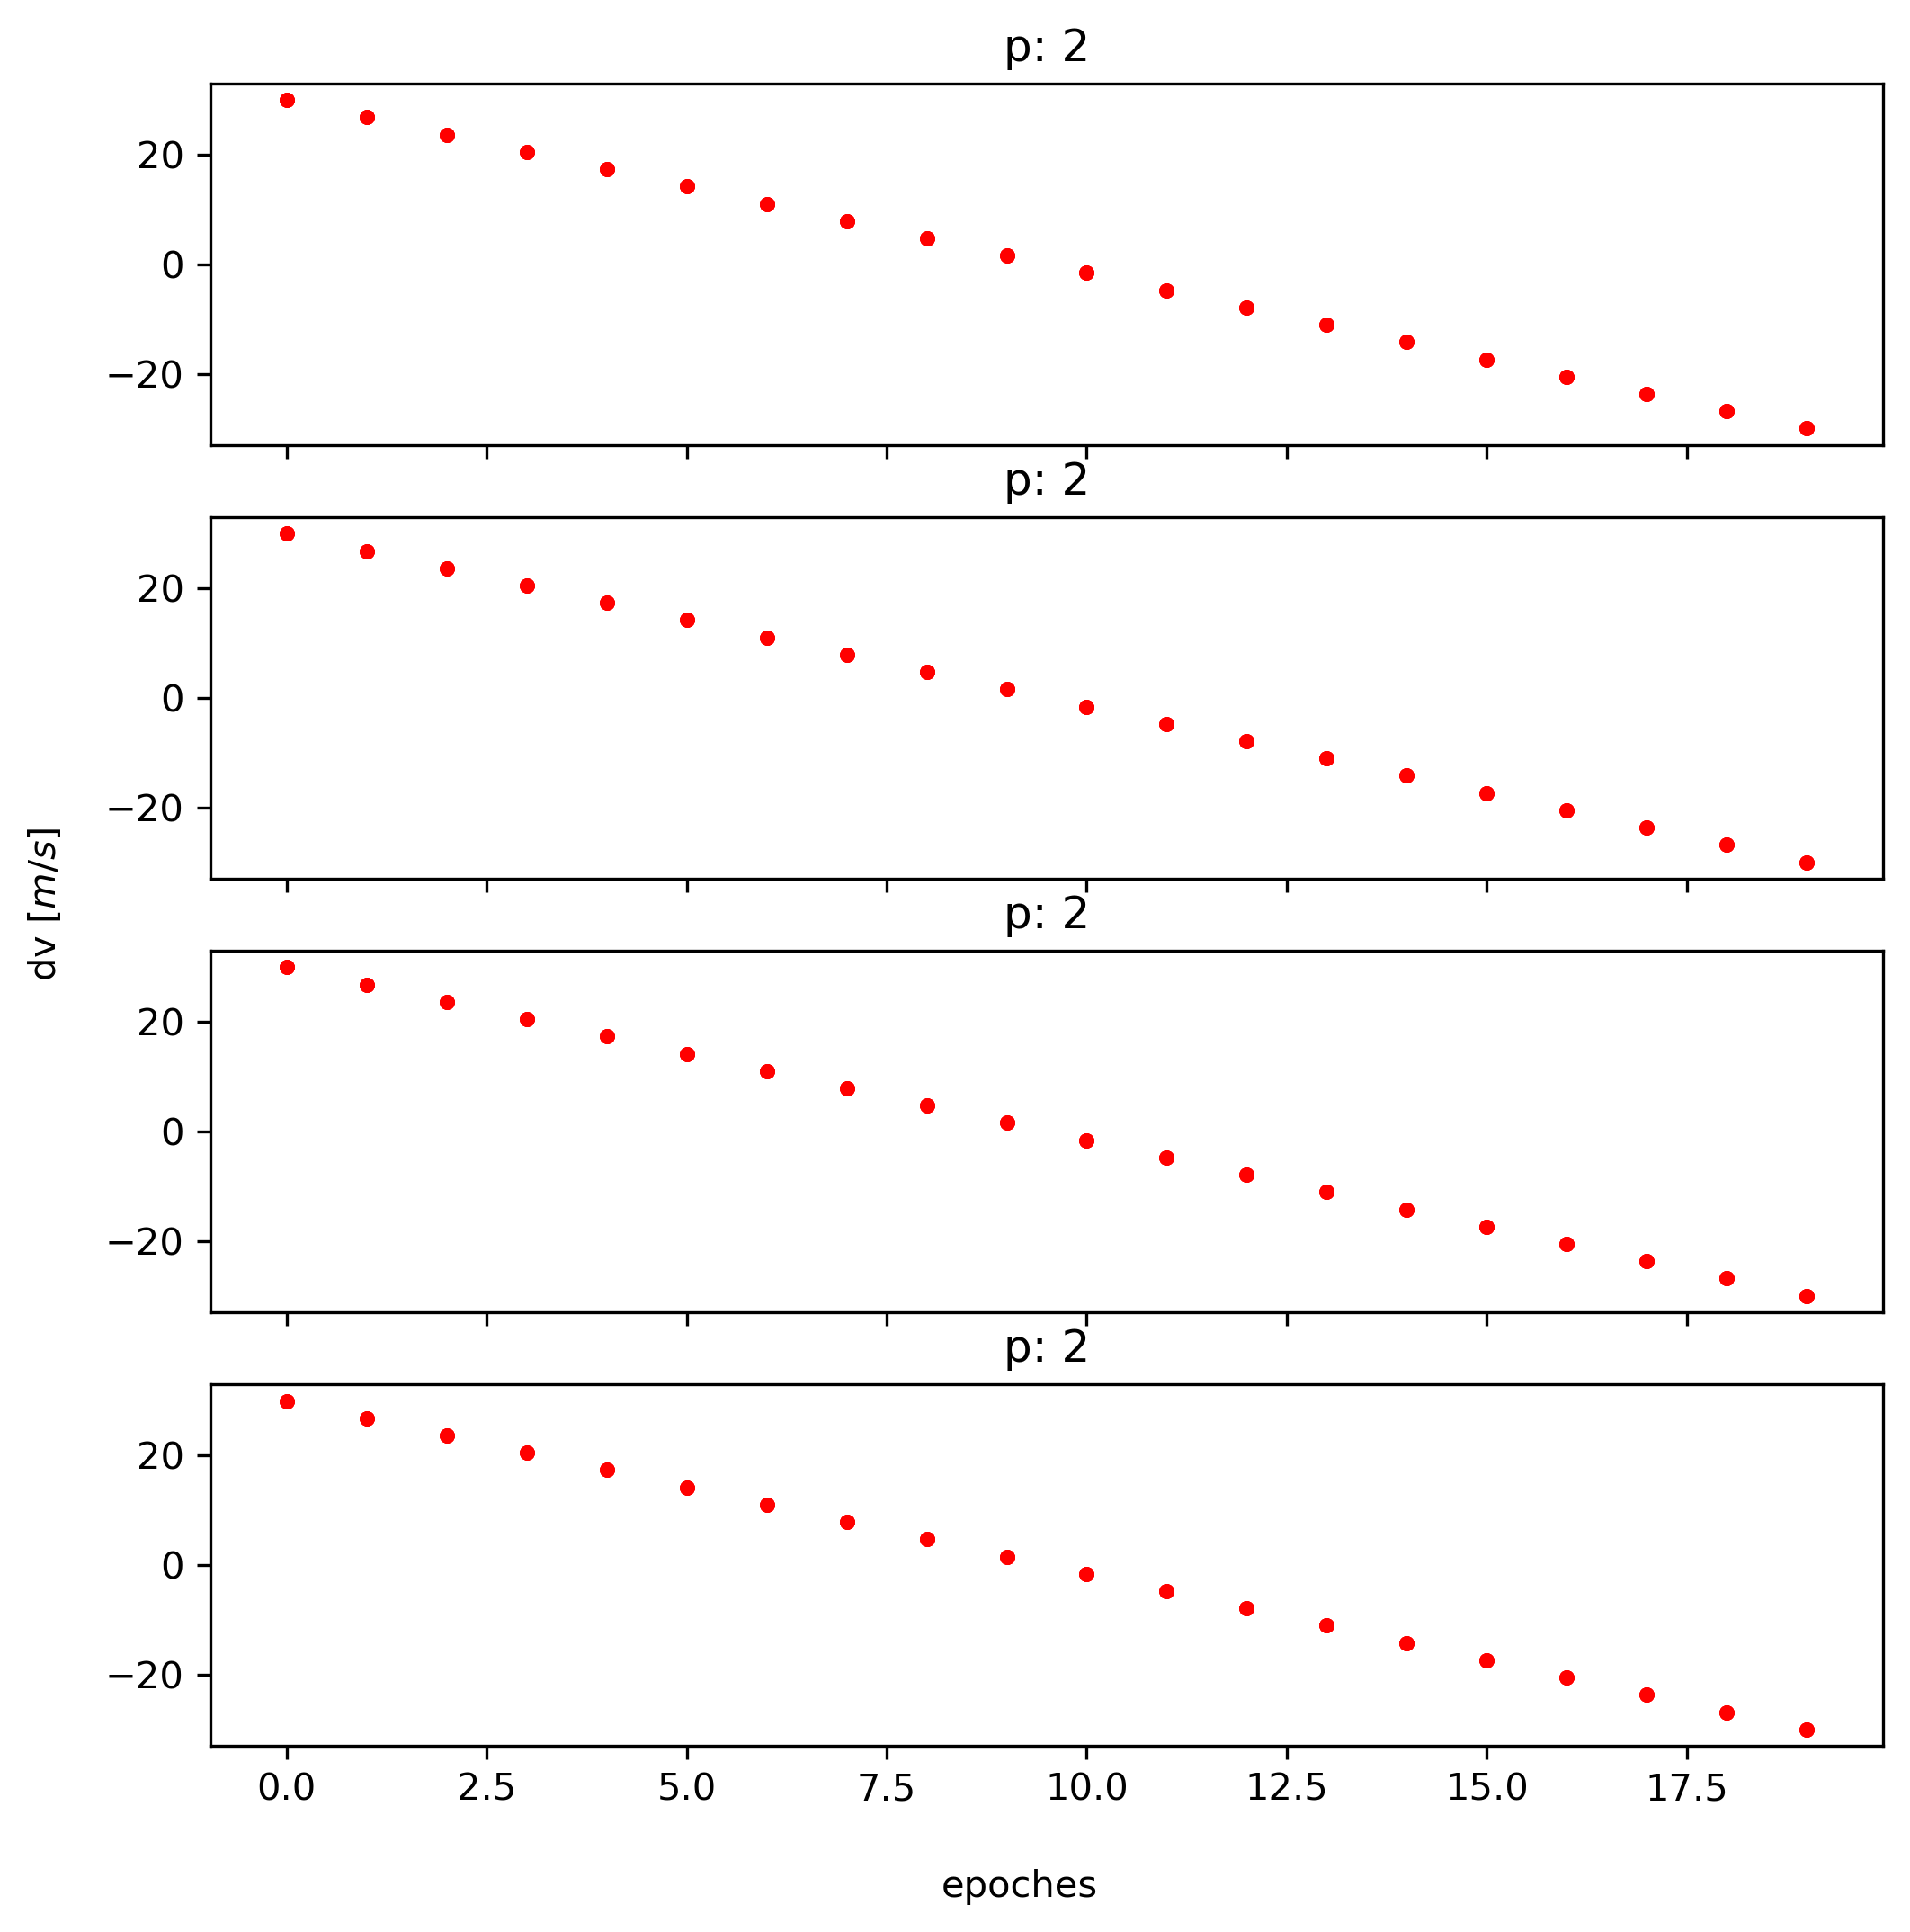

In [15]:
fig,ax = plt.subplots(len(model_set),figsize=(8,8),facecolor=(1,1,1),dpi=300,sharex=True,sharey=True)

epoch_range = np.arange(0,epoches,dtype=int)
# ax.plot(epoch_range,extra_vel.to(u.m/u.s).value,'.g',label='initialization')

for i in range(len(model_set)):
    for j in range(len(datasets)):
        estimate_vel = jabble.dataset.velocities(model_set[i][0][0].p)
        dv = estimate_vel.to(u.m/u.s).value - estimate_vel.to(u.m/u.s).value.mean() - velocities.to(u.m/u.s).value
        ax[i].plot(epoch_range,dv,'.r',label='estimation')
        ax[i].set_title('p: {}'.format(model_set[i][1].p_val))
        
fig.text(0.04, 0.5, 'dv [$m/s$]', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'epoches', ha='center')
plt.savefig(os.path.join(out_dir,'44-dv.png'))
plt.show()

In [16]:
import cProfile, pstats, io
from pstats import SortKey

In [17]:
from dataclasses import dataclass

@dataclass
class MyData:
    xs: np.ndarray
    ys: np.ndarray
    yivar: np.ndarray
    def __index__(*args):
        return MyData(xs[args],ys[args],yivar[args])

In [18]:
class MyChiSquare(jabble.loss.ChiSquare):
    def loss_all(self,p,data,model,*args):
        output = 0.0
        # recall ys are packed st that 0: epoches, 1: pixel
        # if model.save_history:
        #     loss_arr = np.zeros(data.ys.shape)
        def _internal(ind):

            return self(p,data,ind,model,*args).sum()
        return jnp.sum(jax.vmap(_internal, out_axes=0,in_axes=0)(np.arange(data.xs.shape[0])))
        
    def __call__(self, p, data, i, model, *args):
        err = self.coefficient * (((data.ys - model(p,data.xs,i,*args))**2) * data.yivar)
        return err
# loss        = MyChiSquare()
loss = jabble.loss.ChiSquare()

In [19]:
for j in range(len(model_set)):

    print('pval: ',model_set[i][1].p_val,'ds: ',i)
    cProfile.run('model_set[j]=train_cycle(model_set[j],datasets[j],loss)',os.path.join(out_dir,filenames[j]))        

pval:  2 ds:  3
0 27
0 11
0 4
0 9
pval:  2 ds:  3
0 27
0 11
0 4
0 11
pval:  2 ds:  3
0 26
0 11
0 5
0 10
pval:  2 ds:  3
0 31
0 11
0 7
0 16


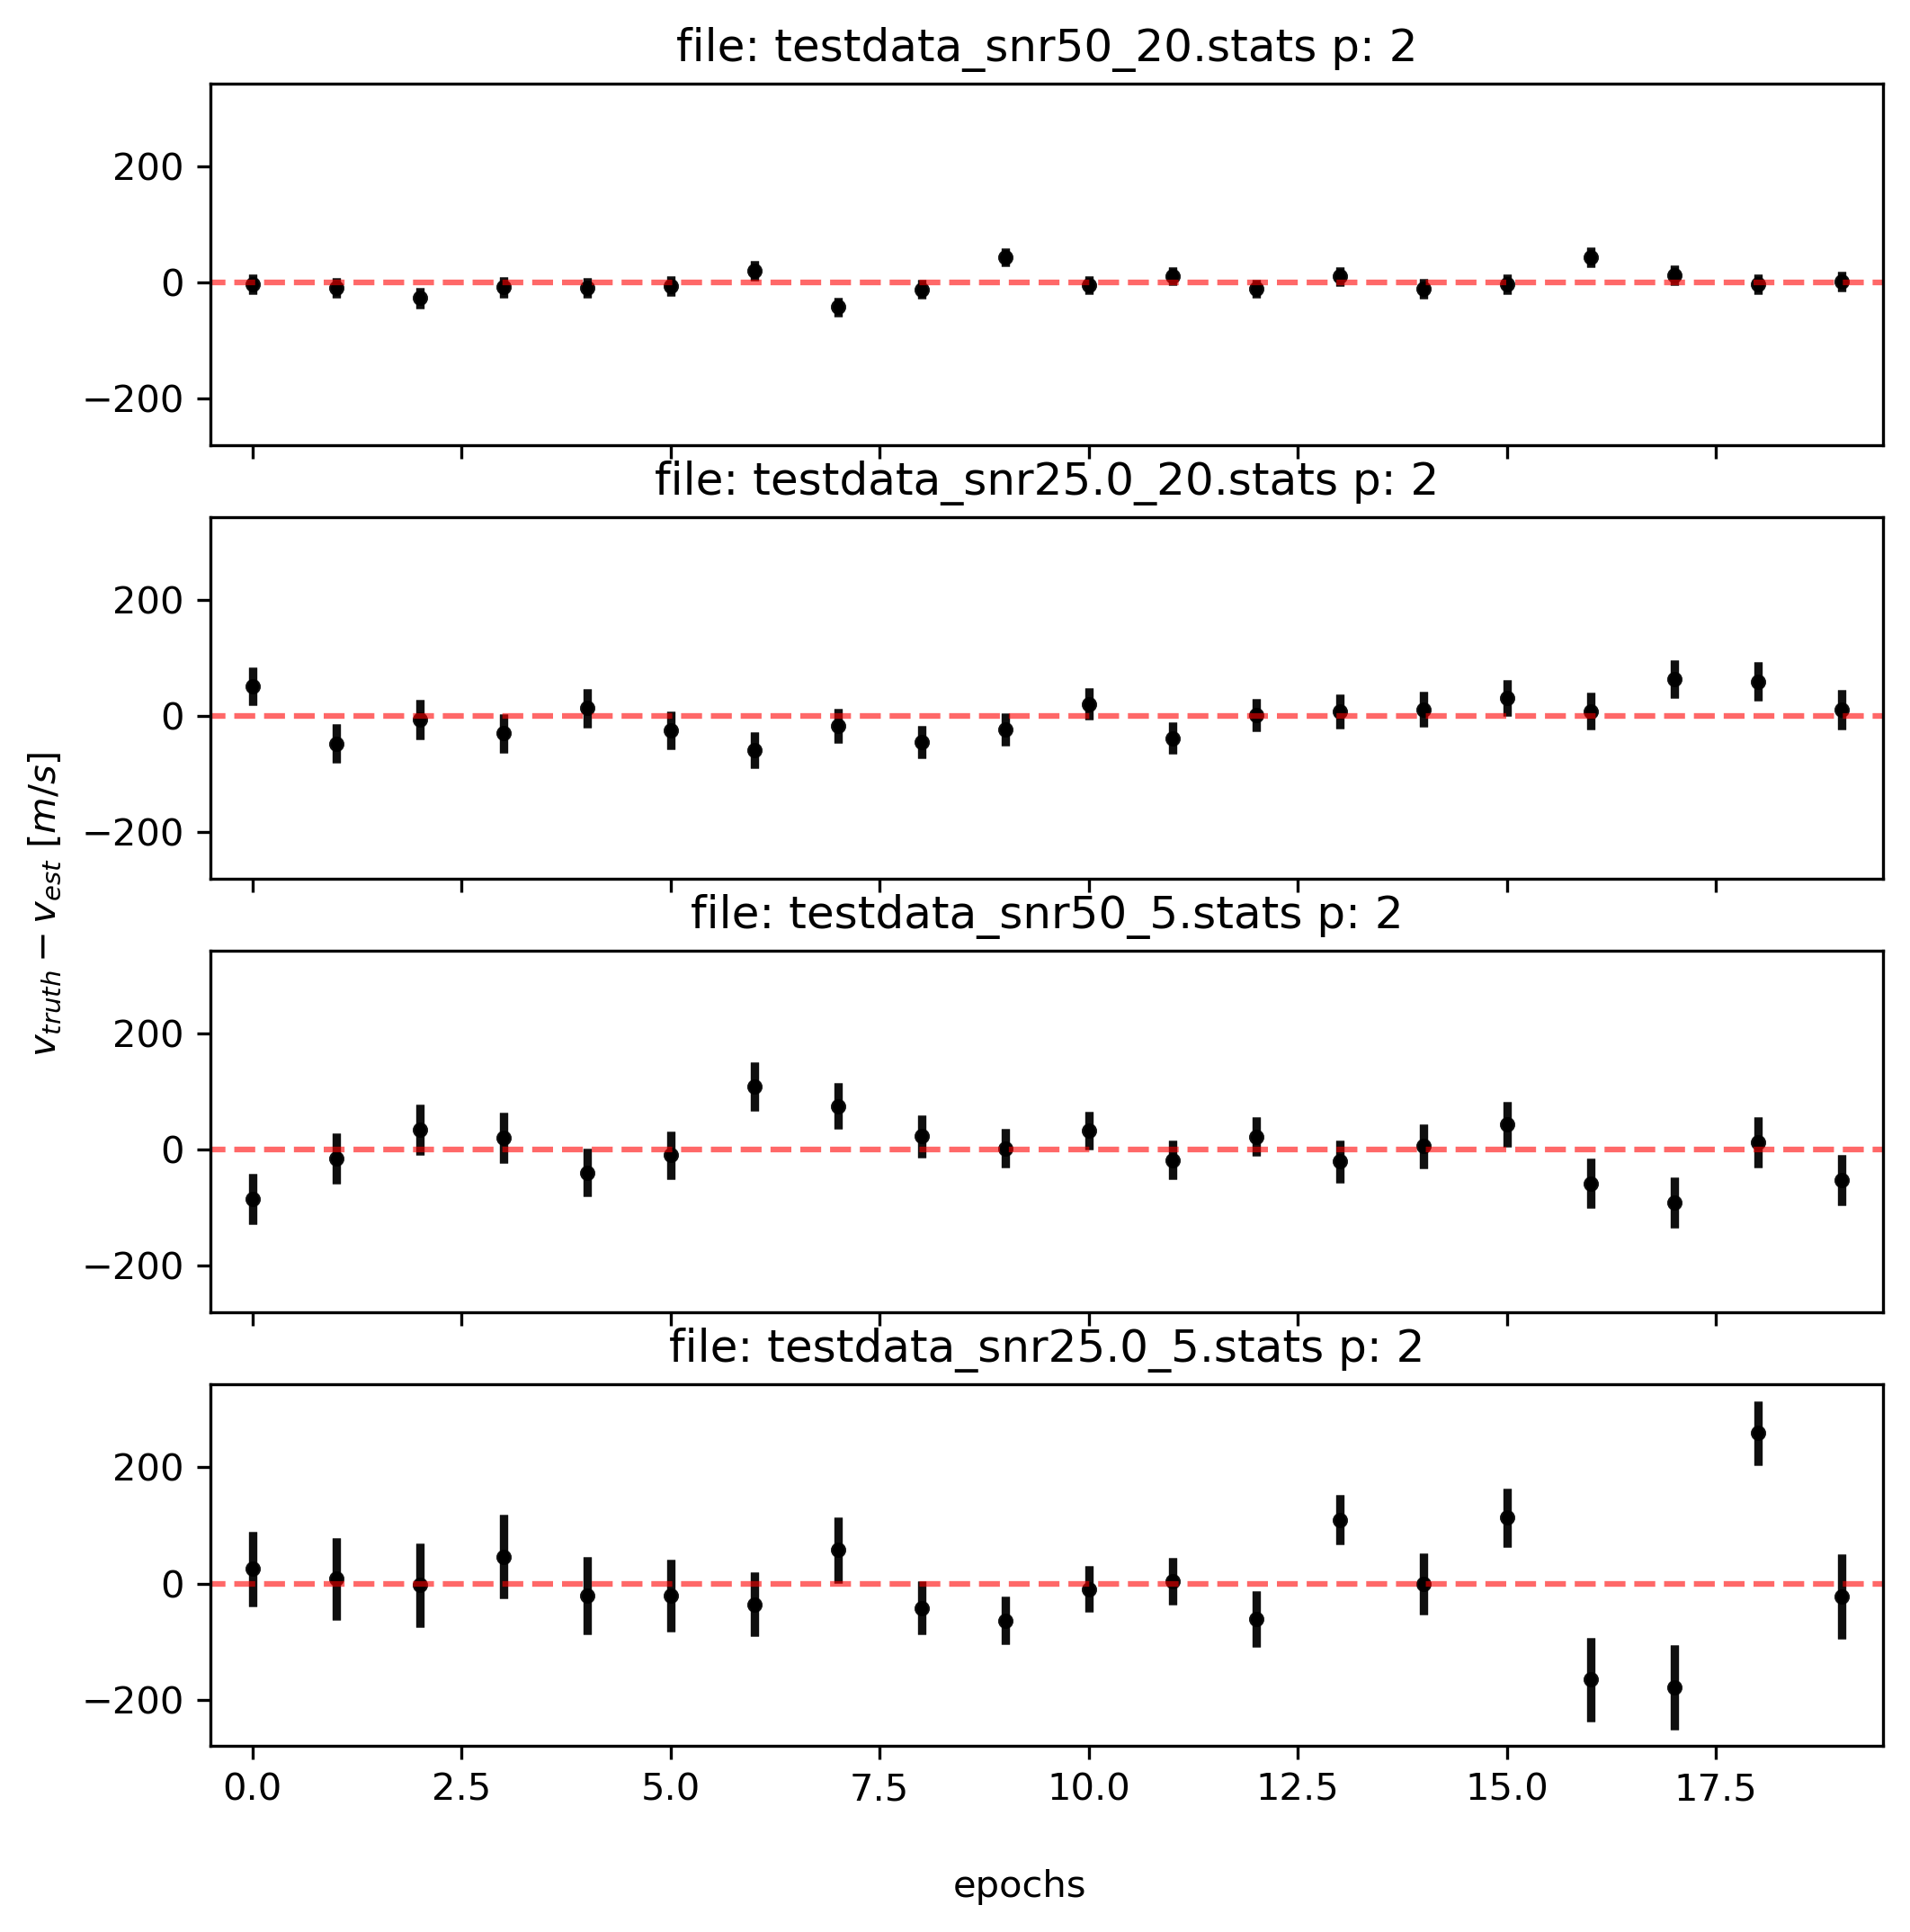

In [20]:
fig,ax = plt.subplots(len(model_set),figsize=(8,8),facecolor=(1,1,1),dpi=300,sharex=True,sharey=True)

epoch_range = np.arange(0,epoches,dtype=int)
# ax.plot(epoch_range,extra_vel.to(u.m/u.s).value,'.g',label='initialization')

for i in range(len(model_set)):
    fischer_information = np.zeros(epoches)
    for e_num in range(epoches):
        model_set[i].fix()
        model_set[i].fit(0,0)
        duddx = jax.jacfwd(model_set[i], argnums=0)(model_set[i].get_parameters(),datasets[i].xs[e_num,:],e_num)
        # print(temp.shape)
        fischer_information[e_num] =  jnp.dot(duddx[:,e_num]**2,datasets[i].yivar[e_num,:])
    
    for j in range(len(datasets)):
        dvddx = jnp.array([jax.grad(jabble.physics.velocities)(x) for x in model_set[i][0][0].p])
        verr = np.sqrt(1/fischer_information) * dvddx
        ax[i].hlines(y = 0.0, xmin = -2, xmax = epoches+2,linestyles='dashed',alpha=0.2,color='red')
        estimate_vel = jabble.dataset.velocities(model_set[i][0][0].p)
        tv = velocities.to(u.m/u.s).value   - velocities.to(u.m/u.s).value.mean()
        ev = estimate_vel.to(u.m/u.s).value - estimate_vel.to(u.m/u.s).value.mean()        
        # ax[i].plot(epoch_range,tv,'.r',alpha=0.5)        
        ax[i].errorbar(epoch_range,tv - ev,yerr=verr,fmt='.k',elinewidth=2.2,zorder=1,alpha=0.5,ms=6)
        ax[i].set_title('file: {} p: {}'.format(filenames[i],model_set[i][1].p_val,len(means_stellar)))
        # ax.set_ylim(-5.5e3,5.5e3)
        # for epoch in epoch_range:
        #     constant = 1e-5
        #     ax.arrow(epoch,dv[epoch],0.0,constant*stellar_model.results[-1].jac[epoch])

        # twin_ax = ax.twinx()
        # twin_ax.plot(stellar_model.results[-1]['jac'][:stellar_model[0].p.shape[0]],'om',alpha=0.3,label='gradient')
        # twin_ax.set_ylim(-1e9,1e9)
# plt.ylabel('dv [m/s]')
# plt.xlabel('epoches')
# plt.legend()
plt.xlim(-0.5,epoches-0.5)
fig.text(0.04, 0.5, '$v_{truth} - v_{est}$ [$m/s$]', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'epochs', ha='center')
plt.savefig(os.path.join(out_dir,'44-dv.png'))
plt.show()

In [21]:
from mpl_axes_aligner import align

In [34]:
def make_plot(model_num):
    x_window = np.log(4550.2) - np.log(4547.5)

    lrange = np.arange(lmin,lmax,1)
    plt_unit = u.Angstrom
    r_plots = 4
    
    vel_epoch = 5
    fig, axes = plt.subplots(epoches // r_plots, r_plots,figsize=(8,8),sharex=False,sharey=True,facecolor=(1, 1, 1),dpi=200)
    fig.suptitle(filenames[model_num])
    for plt_epoch in range(epoches):
        # model_set[model_num].fix()
        # model_set[model_num].fit(0)
        # rv_model_deriv = jax.jacfwd(model_set[model_num], argnums=0)(model_set[model_num].get_parameters(),datasets[model_num].xs[plt_epoch,:],plt_epoch)
        # rv_loss_deriv = jax.jacfwd(loss, argnums=0)(model_set[model_num].get_parameters(),datasets[0],vel_epoch,model_set[model_num])
        
        model_set[model_num].fix()
    
        axes[plt_epoch // r_plots, plt_epoch % r_plots].errorbar(datasets[model_num].xs[plt_epoch,:],datasets[model_num].ys[plt_epoch,:],\
                                 datasets[model_num].yerr[plt_epoch,:],fmt='.k',elinewidth=1.2,zorder=1,alpha=0.5,ms=3)

        true_model.fix()
        xplot = np.linspace(np.log(lmin),np.log(lmax),datasets[0].xs.shape[1]*10)
        axes[plt_epoch // r_plots, plt_epoch % r_plots].plot(xplot,model_set[model_num][0]([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
        axes[plt_epoch // r_plots, plt_epoch % r_plots].plot(xplot,model_set[model_num][1]([],xplot,plt_epoch),'-b',linewidth=1.2,zorder=2,alpha=0.7,ms=6)
        
        # axes[plt_epoch // r_plots, plt_epoch % r_plots].plot(xplot,true_model([],xplot,plt_epoch),'-r',linewidth=1.2,zorder=1,alpha=0.5,ms=6)
    
        
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_ylim(-2,1)
    #         axes[i,j].set_yticks([])
        # axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xticks(np.log(lrange))
        # axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xticklabels(['{:2.0f}'.format(x) for x in lrange])
        plt_min = np.mean(means_tellurics[0])-x_window+model_set[model_num][0][0].p[plt_epoch]
        plt_max = np.mean(means_tellurics[0])+x_window+model_set[model_num][0][0].p[plt_epoch]
        axes[plt_epoch // r_plots, plt_epoch % r_plots].set_xlim(plt_min,plt_max)
    
        res_ax = axes[plt_epoch // r_plots, plt_epoch % r_plots].twinx()
        residual = loss(model_set[model_num].get_parameters(),datasets[model_num],plt_epoch,model_set[model_num])
        res_ax.step(datasets[model_num].xs[plt_epoch,:],residual,where='mid',alpha=0.3,label='residual')
        res_ax.set_ylim(0.0,20)
        res_ax.set_yticks([])
        # res_ax.step(model_set[i][j][1].xs+model_set[i][j][0].p[plt_epoch],\
        #             model_set[i][j].results[-2]['grad'][:],\
        #             where='mid',alpha=0.4,label='residual',zorder=-1)
        # res_ax.set_yticks([])
        
        # res_ax.step(x_grid,\
        #             rv_model_deriv[:,plt_epoch],\
        #             where='mid',alpha=0.4,label='RV Derivative',zorder=-1)
        
    #     res_ax.step(x_grid,\
    #                 rv_loss_deriv[:,plt_epoch],\
    #                 where='mid',alpha=0.4,label='RV Derivative',zorder=-1)
        
    #     align_yaxis(, 0, , 0)
        
        align.yaxes(axes[plt_epoch // r_plots, plt_epoch % r_plots], 0.0, res_ax, 0.0, 2./3.)

    # res.get_shared_y_axes().join(ax1, ax3)
    fig.text(0.5, 0.04, '$\lambda$', ha='center')
    fig.text(0.04, 0.5, 'y', va='center', rotation='vertical')
    # fig.text(0.96, 0.5, '$d \L /d \delta x$', va='center', rotation=270)
    # fig.text(0.96, 0.5, '$d f_{{{ji}}} /d \delta x_k$', va='center', rotation=270)
    fig.text(0.96, 0.5, 'residuals', va='center', rotation=270)
    
    plt.savefig(os.path.join(out_dir,'44-res_{}.png'.format(filenames[model_num])),dpi=300,bbox_inches='tight')
    plt.show()

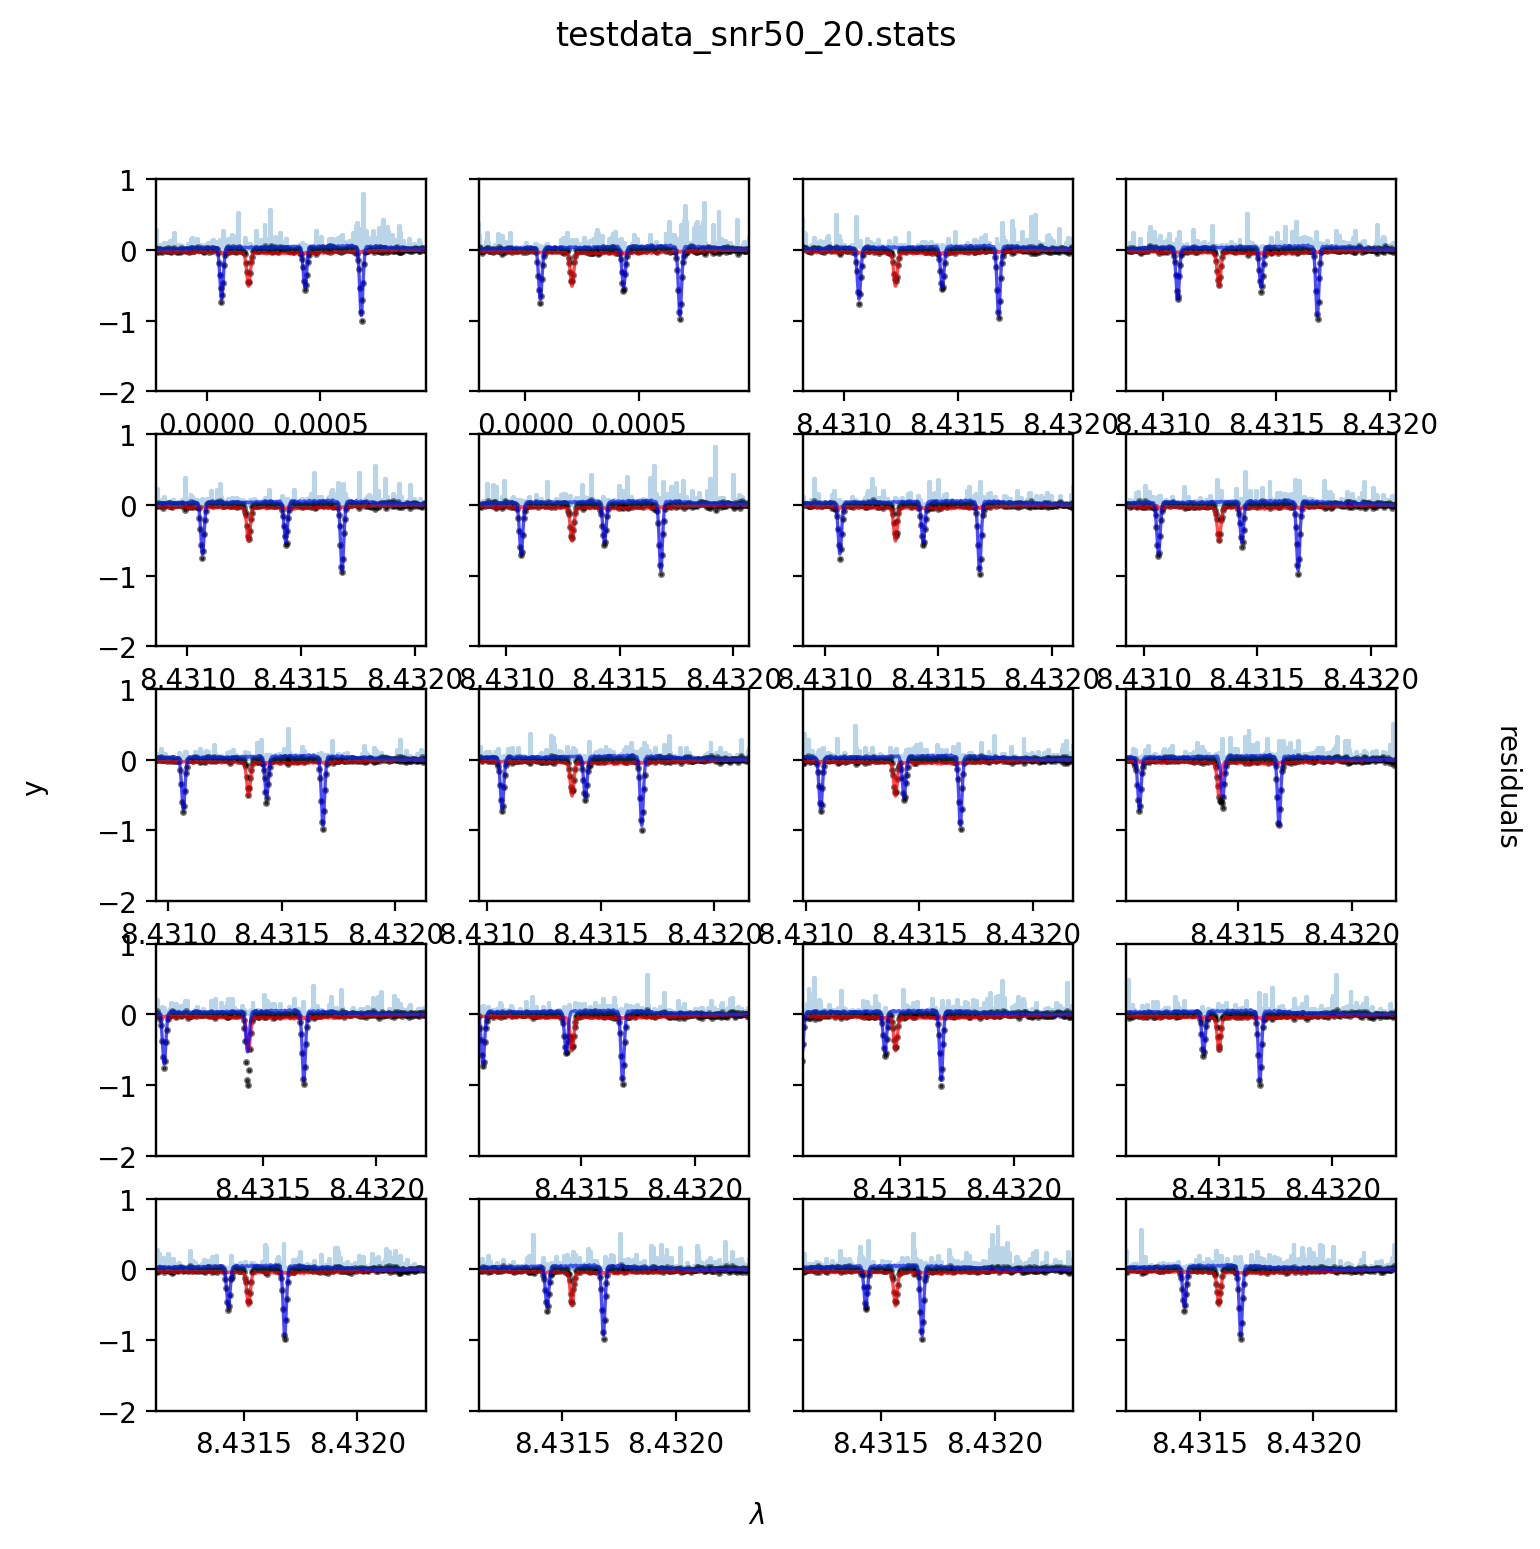

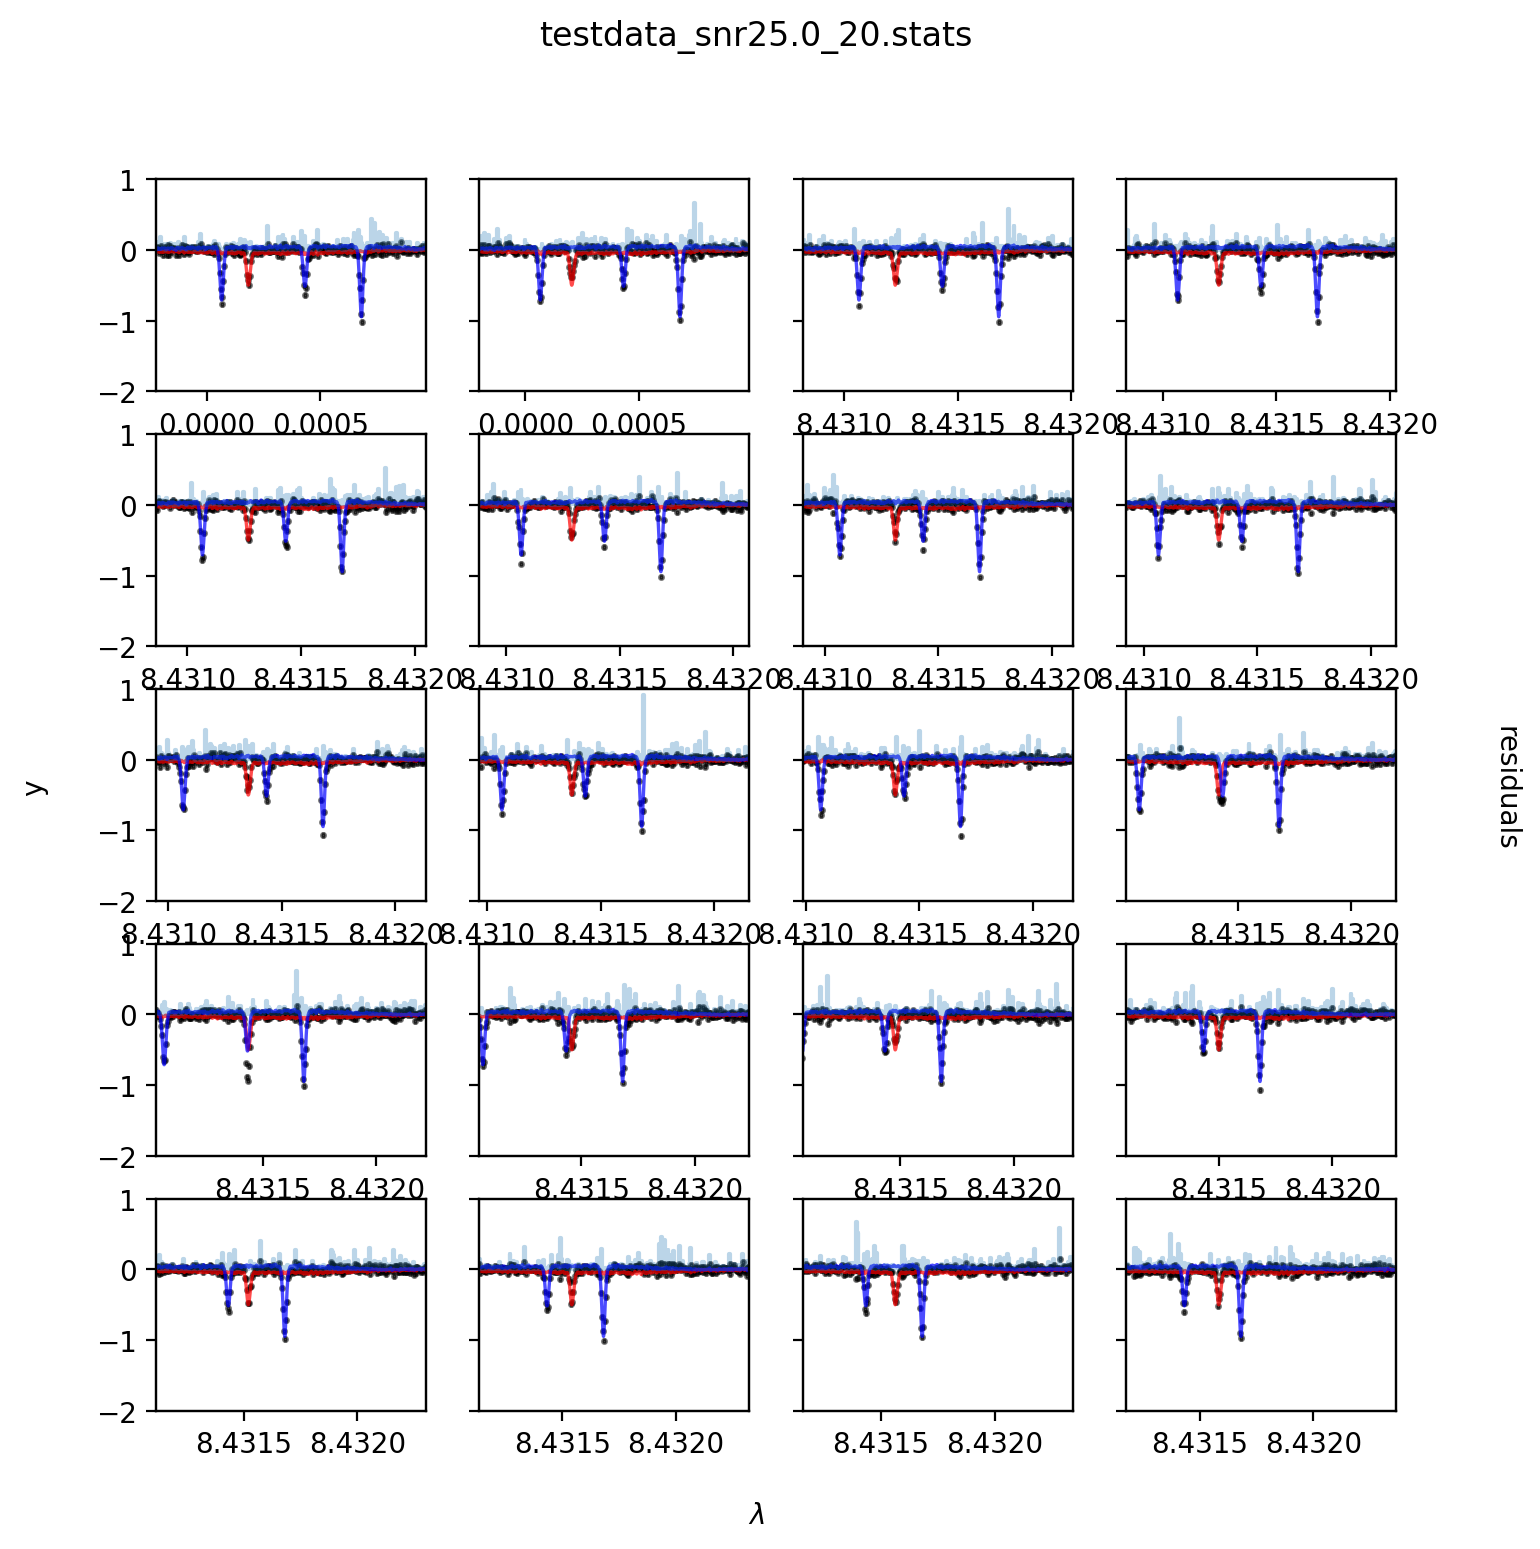

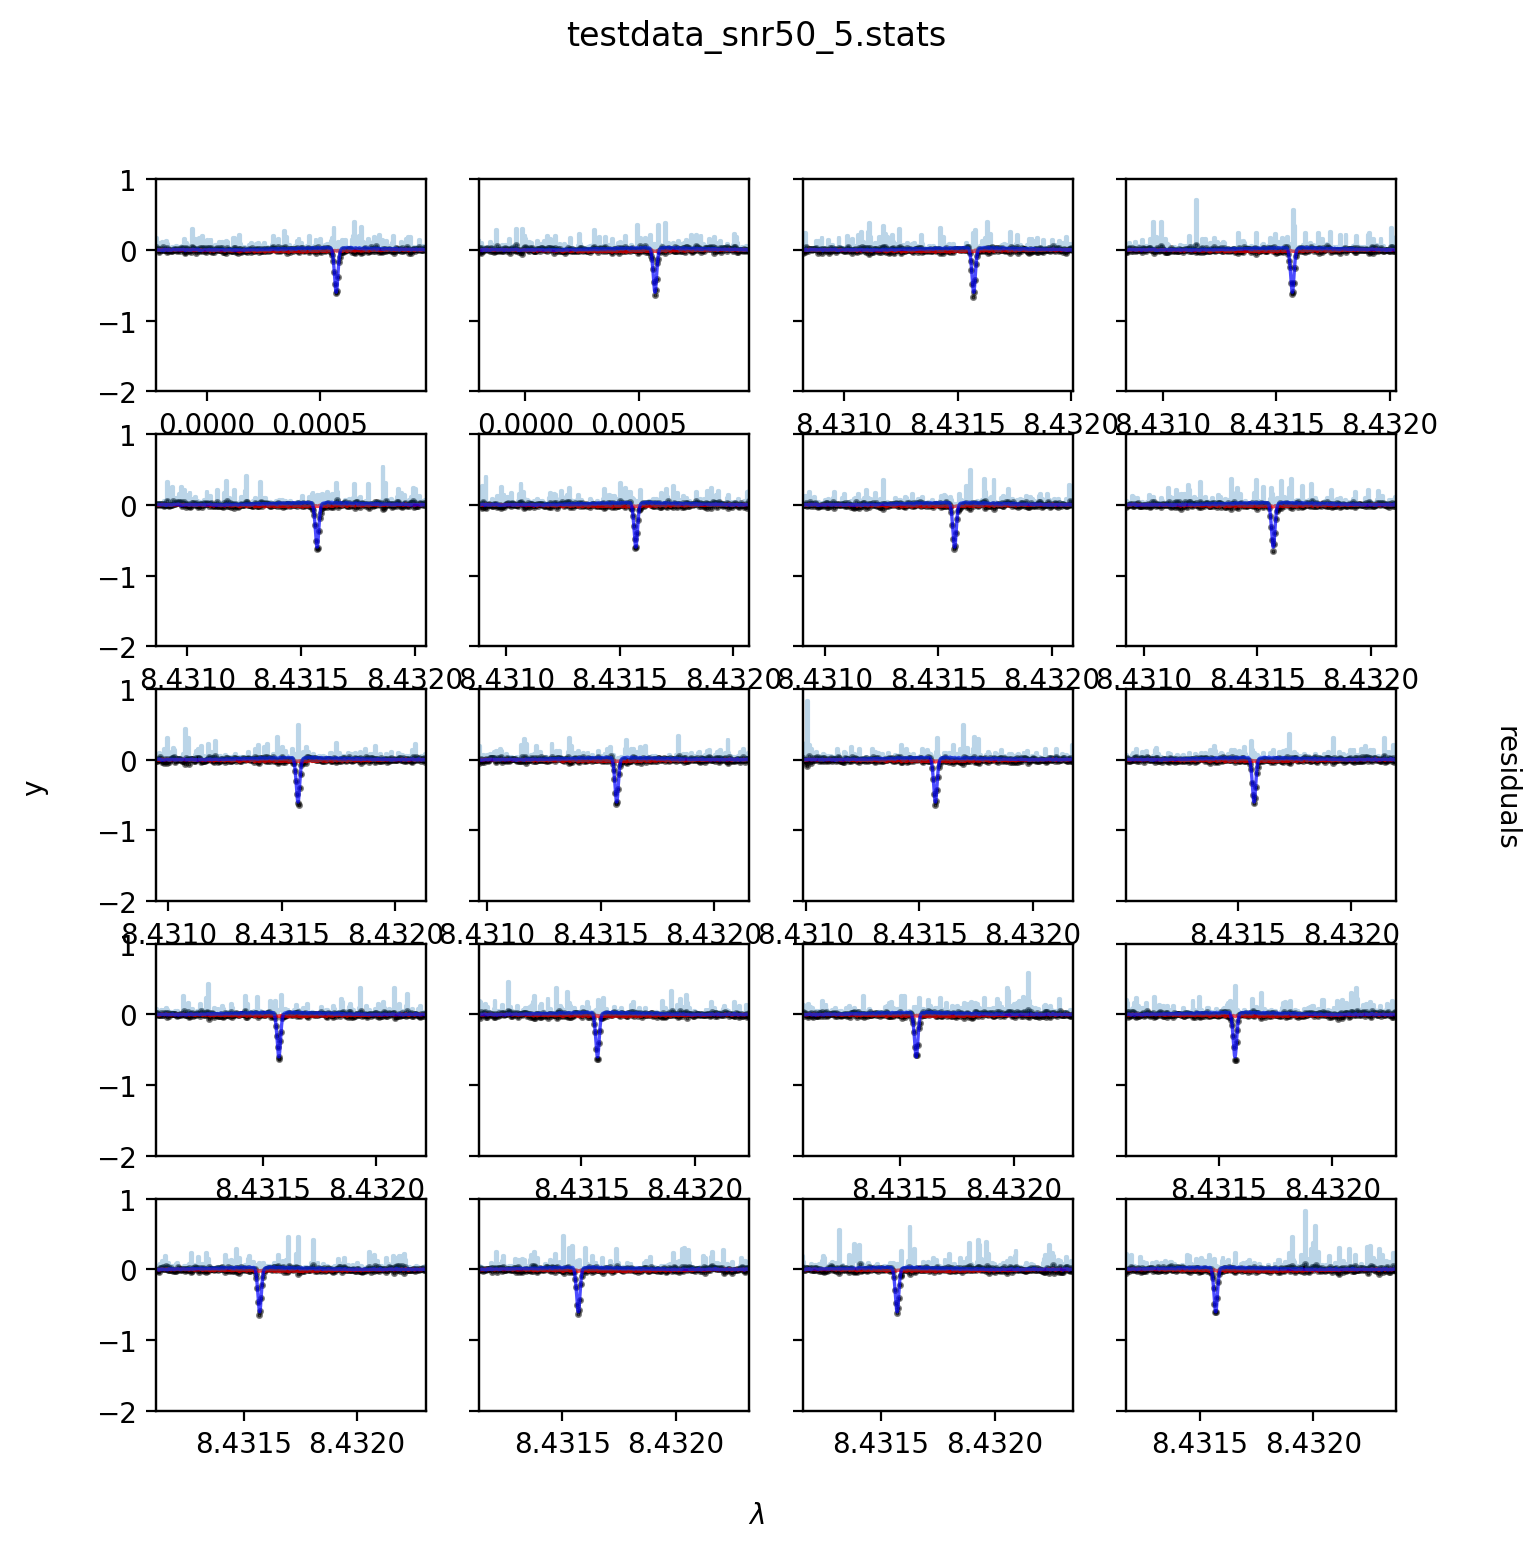

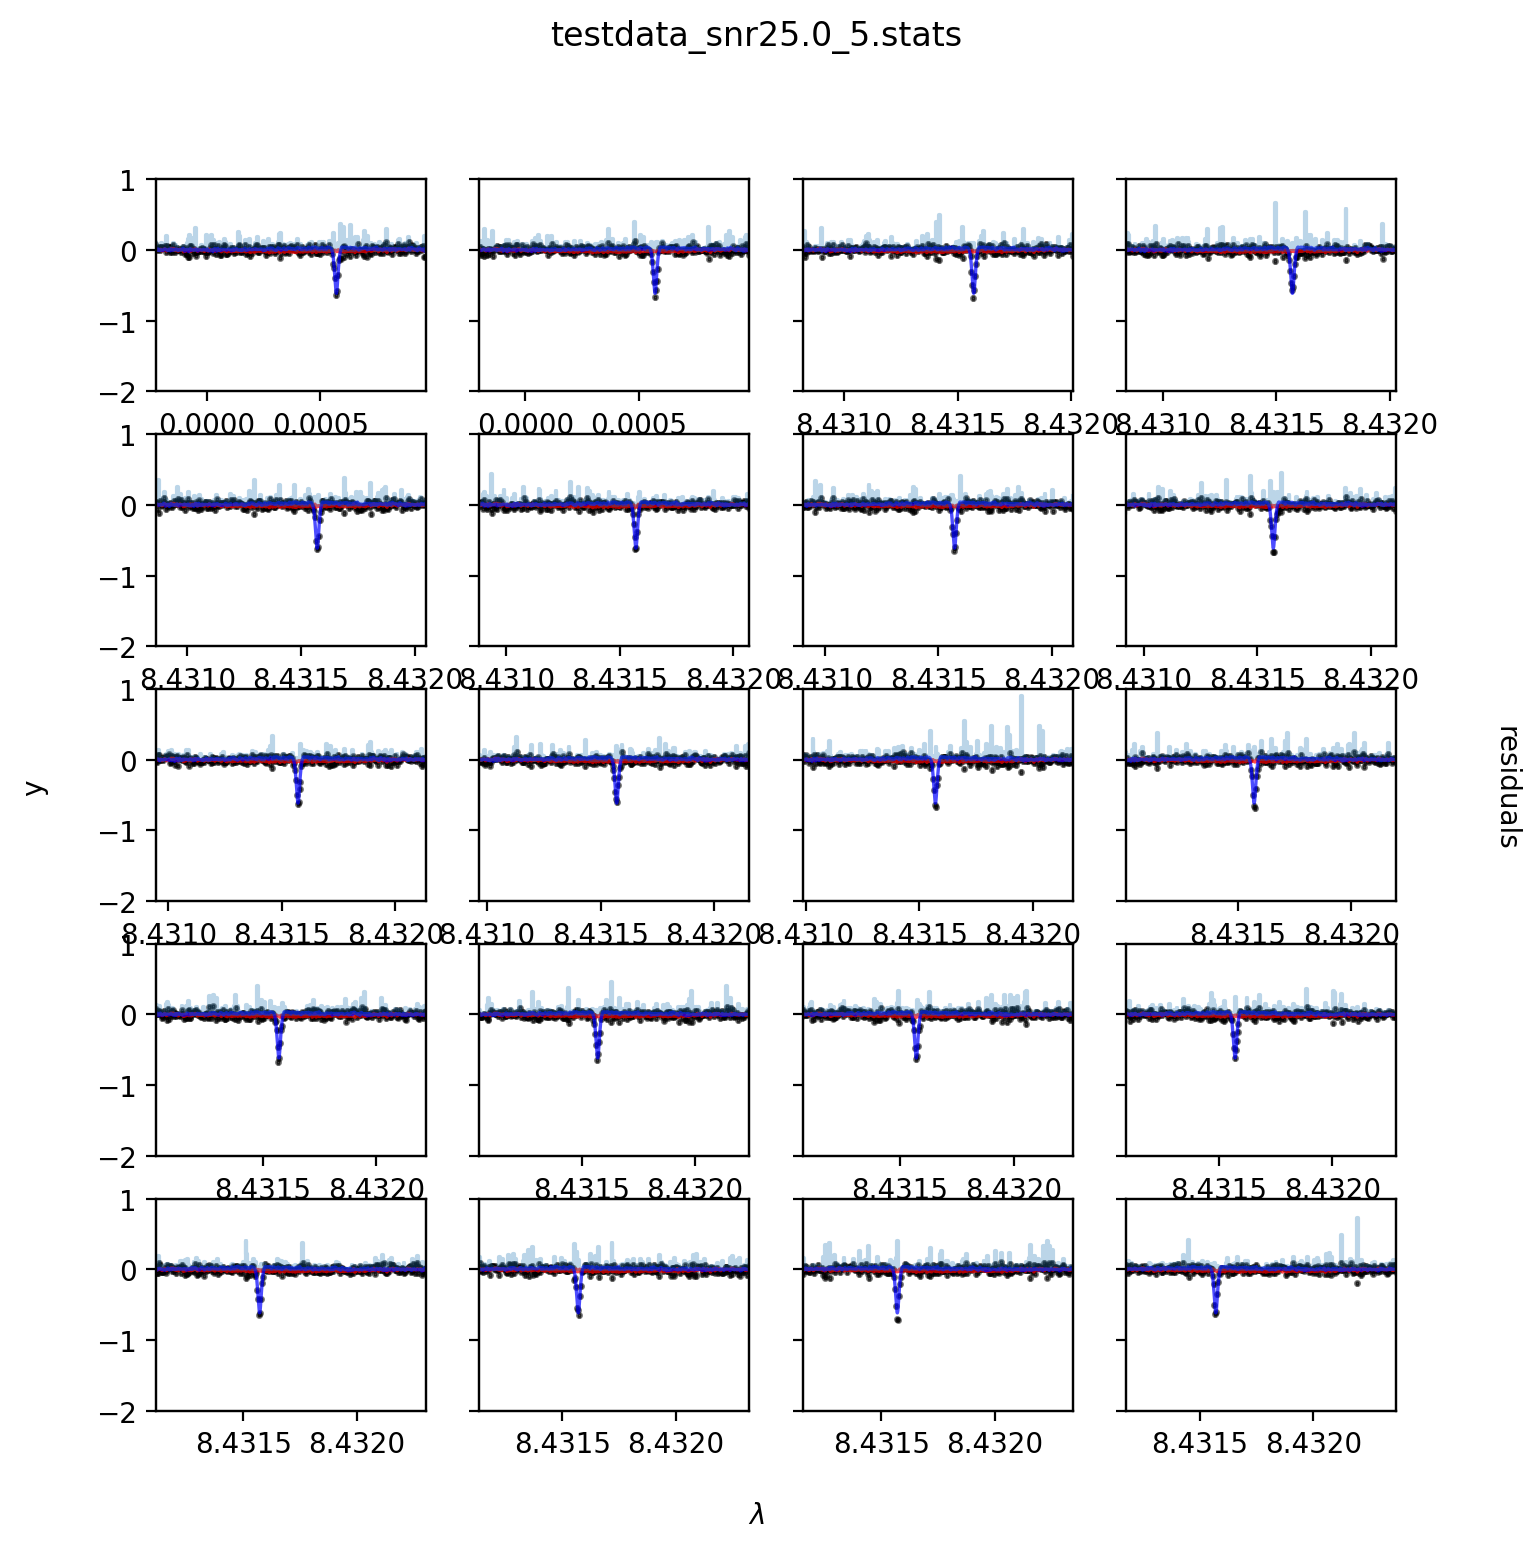

In [35]:
for model_num in range(len(model_set)):
    make_plot(model_num)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


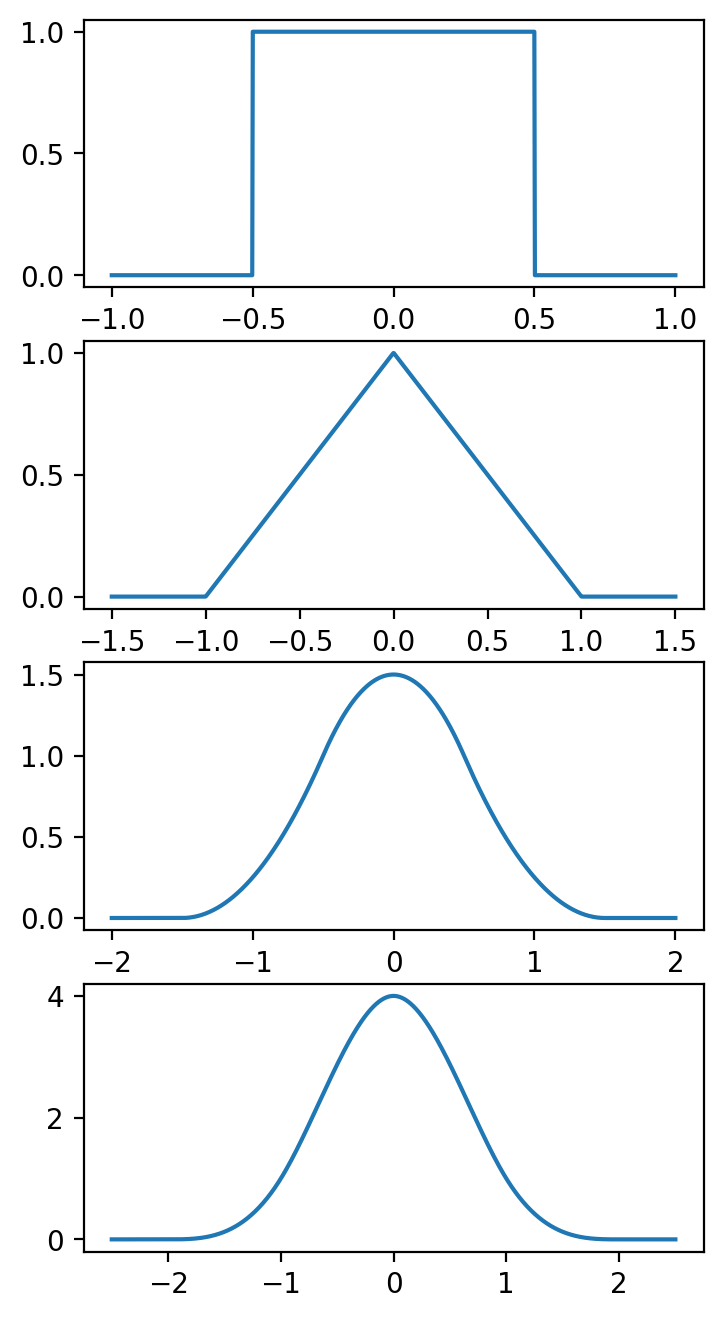

In [4]:

pspace = [0,1,2,3]
fig, axes = plt.subplots(len(pspace),figsize=(4,8),facecolor=(1, 1, 1),dpi=200)

for iii,p in enumerate(pspace):
    xspace = np.linspace(-(p + 2)/2,(p+2)/2,1000)
    spline = jabble.model.IrwinHall(p)
    yspace = spline(xspace)
    axes[iii].plot(xspace,yspace)
plt.savefig(os.path.join(out_dir,'spline_kernel_func.png'))
plt.show()